In [45]:
import pandas as pd
import pickle as pkl
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tqdm.pandas()

# DEFINE VERSION NUMBER AND EXPERIMENT DETAILS



In [46]:
## DEFINE VERSION NUMBER AND EXPERIMENT DETAILS

VERSION = '01'
VERSION_DESCRIPTION = '9 hop negative sample'
OUTPUT_DIR = 'master_files'




versions = pd.read_csv(f'/data/sars-busters-consolidated/{OUTPUT_DIR}/versions.csv', index_col = 'version')
versions = versions.loc[versions.index != int(VERSION)]
versions.loc[VERSION, 'description'] = VERSION_DESCRIPTION
versions.to_csv(f'/data/sars-busters-consolidated/{OUTPUT_DIR}/versions.csv')

In [47]:
edges = pd.read_csv('/data/sars-busters-consolidated/nw_files/WholeNetworkEdgesTable.csv')

In [48]:
nodes = pd.read_csv('/data/sars-busters-consolidated/nw_files/WholeNetworkNodesTable.csv', index_col = 'Id')

In [49]:
#nodes = nodes.set_index('Label')

In [50]:
nodes['Type'].value_counts()

Chemical    8111
Protein     5104
Name: Type, dtype: int64

In [51]:
edges

,Source,Target,Type
0,6093,11246,Undirected
1,10888,3006,Undirected
2,5855,11533,Undirected
3,4812,431,Undirected
4,9288,2799,Undirected
...,...,...,...
30808,7827,8239,Undirected
30809,4369,12682,Undirected
30810,12219,3713,Undirected
30811,10631,11479,Undirected


In [52]:
nodes[nodes['Label'] == 'MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFALNPGLLETSDGCKQIIGQLQPAIRTGSEELRSLFNTVATLYCVHERIEVKDTKEALEKMEEEQNKSKNKKAQQAAADAGNNSQVSQNYPIVQNLQGQMVHQAISPRTLNAWVKVIEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIAPGQMREPRGSDIAGTTSTLQEQIAWMTSNPPIPVGEIYKRWIILGLNKIVRMYSPVSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKGWMTETLLVQNANPDCKTILKALGPQATLEEMMTACQGVGGPSHKARVLAEAMSQATNSAAAVMMQRGNFKGPRKTIKCFNCGKEGHIAKNCRAPRRKGCWKCGKEGHQLKDCTERQANFLREDLAFPQGKAGELSSEQTRANSPTSRELRVWGRDNPLSETGAERQGTVSFNCPQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGKWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNFPISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALTEICTEMEKEGKISRVGPENPYNTPIFAIKKKDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKKKSVTVLDVGDAYFSVPLDKDFRKYTAFTIPSINNETPGIRYQYNVLPQGWKGSPAIFQSSMTKILEPFRKQNPEIVIYQYMDDLYVGSDLEIGQHRTKIEELREHLLRWGFTTPDKKHQKEPPFLWMGYELHPDKWTVQSIKLPEKESWTVNDIQKLVGKLNWASQIYPGIKVRQLCKLLRGTKALTEVIPLTEEAELELAENREILKEPVHGVYYDPSKDLIAEIQKQGHGQWTYQIYQEPFKNLKTGKYARMRGAHTNDVKQLAEVVQKISTESIVIWGKTPKFRLPIQKETWETWWVEYWQATWIPEWEFVNTPPLVKLWYQLEKEPIIGAETFYVDGAANRETKLGKAGYVTDRGRQKVVPFTDTTNQKTELQAINLALQDSGLEVNIVTDSQYALGIIQAQPDKSESELVSQIIEQLIKKEKVYLAWVPAHKGIGGNEQVDKLVSQGIRKVLFLDGIDKAQEEHEKYHNNWRAMASDFNLPPVVAKEIVASCDKCQLKGEAMHGQVDCSPGIWQLDCTHLEGKVILVAVHVASGYIEAEVIPAETGQETAYFILKLAGRWPVKIVHTDNGSNFTSAAVKAACWWAGIKQEFGIPYNPQSQGVVESMNKELKKIIGQVRDQAEHLKTAVQMAVFIHNFKRKGGIGGYSAGERIIDIIATDIQTKELQKQITKIQNFRVYYRDSRDPIWKGPAKLLWKGEGAVVIQDNSDIKVVPRRKVKIIRDYGKQMAGDDCVASRQDED']

,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2
Id,,,,,,,
8067,MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFAL...,Protein,False,False,True,False,Protein


## Get Centrality Scores

In [53]:
G = nx.Graph()
G.add_edges_from(list(zip(list(edges['Source']), list(edges['Target']))))
nx.is_bipartite(G)

True

In [54]:
len(G.nodes)

13215

In [55]:
centrality = nx.algorithms.centrality.betweenness_centrality(G, k = int(len(G.nodes)/10)) # k is the node samples used 

In [56]:
nodes['centrality'] = nodes.index.map(centrality)

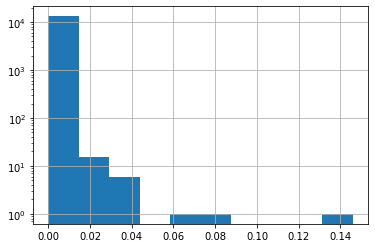

In [57]:
nodes['centrality'].hist(log = True)

In [58]:
node_centrality_map = dict(zip(nodes['Label'].tolist(), nodes['centrality'].tolist()))

In [59]:
centrality_mean = np.mean(list(node_centrality_map.values()))

In [60]:
centrality_std = np.std(list(node_centrality_map.values()))

In [61]:
centrality_std

0.0020530184675598157

In [62]:
centrality_mean

0.00029904385426115886

In [64]:
with open ('/data/covid-target-finder/raw_network_combined/shortest_path_bp_Total.pkl', 'rb') as f:
    
    shortest_paths = pkl.load(f)

In [28]:
len(shortest_paths)

12079

In [29]:
len(set([i for i in shortest_paths.keys() if '-' in i]))

7468

In [30]:
len(set([i for i in shortest_paths.keys() if '-' not in i]))

4611

In [31]:
global key_error_count

key_error_count = 0

In [41]:
flatten = lambda l: [item for sublist in l for item in sublist]

def get_neg_path_lengths(U):
        
    try:
    
        path_lengths = [[i,len(v)-1] for i,v in shortest_paths[U].items()][::-1]

        path_lengths = [i for i in path_lengths if (i[1] % 2 != 0) and (i[1] > 1)]
        
        #path_lengths = [[i, float((len(v)-1) / (node_centrality_map[U] + 0.1))] for i,v in shortest_paths[U].items()][::-1]

        cutoff_index = int(len(path_lengths) * 0.01)
        
    except KeyError as e:
        
        return []
        
    
    return [v[1] for v in path_lengths[:cutoff_index]]
    


def get_path_lengths(U):
        
    try:
    
        path_lengths = [[i,len(v)-1] for i,v in shortest_paths[U].items()][::-1]

        path_lengths = [i for i in path_lengths if (i[1] % 2 != 0)]

        
    except KeyError as e:
        
        return []
        
    
    return [v[1] for v in path_lengths]



def get_negative_edges(U):
        
    try:
    
        ## Getting shortest paths
        path_lengths = [[i,len(v)-1] for i,v in shortest_paths[U].items()]
        
        ## Top/Bottom of bipartite nw. Remove positive samples
        path_lengths = [i for i in path_lengths if (i[1] % 2 != 0) and (i[1] > 1)]
        
        
        #path_lengths = [[i[0], float((i[1]) \
        #                    * (node_centrality_map[i[0]] - centrality_mean)/centrality_std)] \
        #                        for i in path_lengths][::-1] # computing centrality for neighbors of U

        #path_lengths = [[i[0], i[1]] for i in path_lengths][::-1]
        
        #cutoff_index = int(len(path_lengths) * 0.01)
        #cutoff_index = 11
        
        
    except KeyError as e:
        
        return []
        
    return [[U,v[0]] for v in path_lengths if v[1] >= 9] # was == 7 hops 
    #return [[U,v[0]] for v in path_lengths[:cutoff_index]]


def get_random_negative_edges(U):
        
    try:
    
        ## Getting shortest paths
        path_lengths = [[i,len(v)-1] for i,v in shortest_paths[U].items()]
        
        ## Top/Bottom of bipartite nw. Remove positive samples
        path_lengths = [i for i in path_lengths if (i[1] % 2 != 0) and (i[1] > 1)]
        
        path_lengths = [[i[0], i[1]] \
                                for i in path_lengths][::-1] 
    
        cutoff_index = int(len(path_lengths) * 0.01)
        
        random_indices =  list(np.random.choice(np.arange(0,len(path_lengths)), size = cutoff_index))        

        return [[U,v[0]] for v in list(np.array(path_lengths)[random_indices])]
    
    except KeyError as e:
        return []
                
    
def get_positive_edges(U):
    
    try:
    
        path_lengths = [[i,len(v)-1] for i,v in shortest_paths[U].items()][::-1]

        path_lengths = [i for i in path_lengths if (i[1] == 1)]
        
    except KeyError as e:
        
        return []
        
    
    return [[U,v[0]] for v in path_lengths]
    

In [36]:
nodes

,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2,centrality
Id,,,,,,,,
1,IDYZIJYBMGIQMJ-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,0.000032
2,JGWRKYUXBBNENE-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,0.000364
3,RPWFJAMTCNSJKK-UHFFFAOYSA-N,Chemical,False,True,False,False,Just NDM,0.000000
4,HUJXISJLAPAFBO-IBGZPJMESA-N,Chemical,True,False,False,False,Just DrugBank,0.000000
5,HDWIHXWEUNVBIY-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,0.000068
...,...,...,...,...,...,...,...,...
13211,MGSNLSPQLCLMPFILGLLSGGVTTTPWSLARPQGSCSLEGVEIKG...,Protein,False,False,True,False,Protein,0.000210
13212,OHCQJHSOBUTRHG-HBQIERAFNA-N,Chemical,False,False,False,False,Chemical,0.000031
13213,XJNKUWDMCBZMTG-OAHLLOKOSA-N,Chemical,True,False,False,False,Just DrugBank,0.000000


In [38]:
all_paths = nodes['Label'].map(get_path_lengths)

In [39]:
all_paths_flat = flatten(list(all_paths.values))

(array([8.72166266e-04, 0.00000000e+00, 1.01698803e-01, 0.00000000e+00,
        5.06435177e-01, 0.00000000e+00, 3.21967845e-01, 0.00000000e+00,
        6.14987135e-02, 0.00000000e+00, 7.01156860e-03, 0.00000000e+00,
        4.91448397e-04, 0.00000000e+00, 2.34354935e-05, 8.42167672e-07]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17.]),
 <a list of 16 Patch objects>)

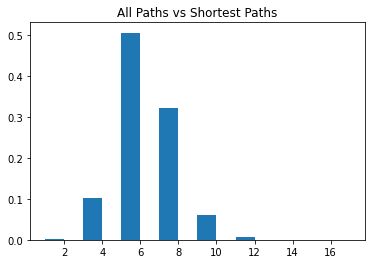

In [40]:
plt.title('All Paths vs Shortest Paths')
plt.hist(all_paths_flat, bins = 16, density = True)

In [42]:
neg_paths = nodes['Label'].map(get_neg_path_lengths)

In [43]:
neg_paths_flat = flatten(list(neg_paths.values))

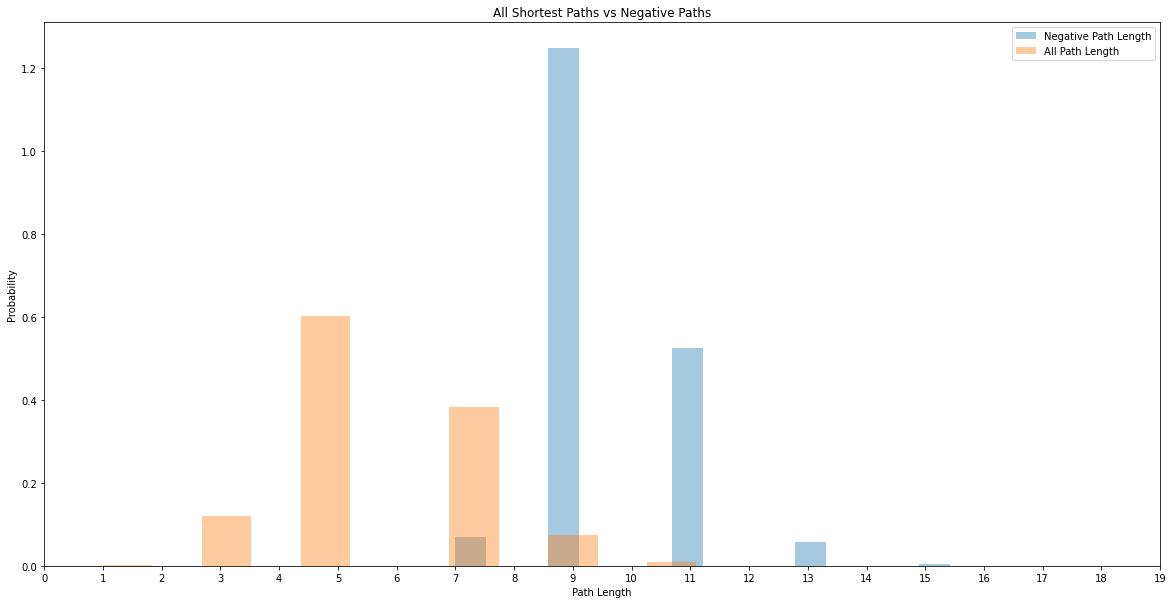

In [44]:
plt.figure(figsize=(20,10))
plt.title('All Shortest Paths vs Negative Paths')
#plt.hist(neg_paths_flat, bins = 16, density = True)

ax = sns.distplot(neg_paths_flat, label = 'Negative Path Length', norm_hist = True, bins = 19, kde = False)
ax = sns.distplot(all_paths_flat, label = 'All Path Length', norm_hist = True, bins = 19, kde = False)

ax.set(xlabel='Path Length', ylabel='Probability')
plt.xticks(np.arange(0, 20, step=1))

plt.legend()
plt.show()

In [35]:
nodes

,Label,Type,IsDrug,IsNDM,IsDrugTarget,IsNDMTarget,Type2,centrality
Id,,,,,,,,
1,IDYZIJYBMGIQMJ-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,0.000017
2,JGWRKYUXBBNENE-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,0.000338
3,RPWFJAMTCNSJKK-UHFFFAOYSA-N,Chemical,False,True,False,False,Just NDM,0.000000
4,HUJXISJLAPAFBO-IBGZPJMESA-N,Chemical,True,False,False,False,Just DrugBank,0.000000
5,HDWIHXWEUNVBIY-UHFFFAOYSA-N,Chemical,True,False,False,False,Just DrugBank,0.000038
...,...,...,...,...,...,...,...,...
13211,MGSNLSPQLCLMPFILGLLSGGVTTTPWSLARPQGSCSLEGVEIKG...,Protein,False,False,True,False,Protein,0.000445
13212,OHCQJHSOBUTRHG-HBQIERAFNA-N,Chemical,False,False,False,False,Chemical,0.000009
13213,XJNKUWDMCBZMTG-OAHLLOKOSA-N,Chemical,True,False,False,False,Just DrugBank,0.000000


In [17]:
nodes['Label'][:5].map(get_random_negative_edges)

Id
1    [[IDYZIJYBMGIQMJ-UHFFFAOYSA-N, MLLLLLVPLFLRPLG...
2    [[JGWRKYUXBBNENE-UHFFFAOYSA-N, MAKGFYISKSLGILG...
3                                                   []
4    [[HUJXISJLAPAFBO-IBGZPJMESA-N, MKKIWLALAGLVLAF...
5    [[HDWIHXWEUNVBIY-UHFFFAOYSA-N, MREIVHIQAGQCGNQ...
Name: Label, dtype: object

In [149]:
np.arange(1, 20, 2)[[0,1]]

array([1, 3])

In [54]:
negative_pairs = nodes['Label'].map(get_negative_edges) ## Exactly == 7 hop edges 

In [36]:
negative_pairs

Id
1        [[IDYZIJYBMGIQMJ-UHFFFAOYSA-N, MAALRVLLSCVRGPL...
2        [[JGWRKYUXBBNENE-UHFFFAOYSA-N, MSRRSLSLWFPLLLL...
3                                                       []
4        [[HUJXISJLAPAFBO-IBGZPJMESA-N, MLKPALEPRGGFSFE...
5        [[HDWIHXWEUNVBIY-UHFFFAOYSA-N, PQITLWQRPLVTIKI...
                               ...                        
13211    [[MGSNLSPQLCLMPFILGLLSGGVTTTPWSLARPQGSCSLEGVEI...
13212    [[OHCQJHSOBUTRHG-HBQIERAFNA-N, MSLIATVGPTGGVKN...
13213    [[XJNKUWDMCBZMTG-OAHLLOKOSA-N, MVQAPSVYVCGFVER...
13214    [[HRRHGLKNOJHIGY-UHFFFAOYSA-N, MSPAPVQVMGVLNVT...
13215    [[KYNFOMQIXZUKRK-UHFFFAOYSA-N, MAEAPPRRLGLGPPP...
Name: Label, Length: 13215, dtype: object

In [55]:
negative_pairs = flatten(list(negative_pairs))
negative_pairs = pd.DataFrame(negative_pairs, columns = ['Source', 'Target'])

id_node_inv_map = {v:i for i,v in nodes['Label'].to_dict().items()}

negative_pairs['Source'] = negative_pairs['Source'].map(id_node_inv_map)
negative_pairs['Target'] = negative_pairs['Target'].map(id_node_inv_map)

In [56]:
negative_pairs['Target'][0]

2022

In [57]:
negative_pairs['Type'] = 'Undirected'

In [58]:
negative_pairs

,Source,Target,Type
0,1,2022,Undirected
1,1,3550,Undirected
2,1,2304,Undirected
3,1,11122,Undirected
4,1,11334,Undirected
...,...,...,...
22173887,13215,347,Undirected
22173888,13215,5067,Undirected
22173889,13215,1690,Undirected
22173890,13215,2485,Undirected


In [59]:
edges['Source'].map(nodes['Label'].to_dict()).str.contains('-')

0           True
1           True
2           True
3           True
4           True
            ... 
26927701    True
26927702    True
26927703    True
26927704    True
26927705    True
Name: Source, Length: 26958519, dtype: bool

## Combine Positive(edges) and negative DF

In [88]:
edges['Y'] = 1

In [89]:
negative_pairs['Y'] = 0

In [90]:
#edges = pd.concat([edges, negative_pairs.sample(frac = 0.10)]) # .sample(frac = 0.15)]) # randomly choosing 15% of the neg samples # use for version 03

edges = pd.concat([edges, negative_pairs]) # .sample(frac = 0.15)]) # randomly choosing 15% of the neg samples # use for version 03



In [91]:
len(edges)

22204705

## Verify Integrity of DataFrame

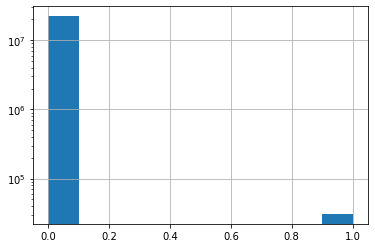

In [92]:
edges['Y'].hist(log = True)

In [93]:
edges['Y'].value_counts()

0    22173892
1       30813
Name: Y, dtype: int64

In [94]:
len(edges.drop_duplicates(['Source', 'Target']))/len(edges)

1.0

In [95]:
edges = edges.drop_duplicates(['Source', 'Target'])

In [96]:
edges[edges['Target'] == None]

,Source,Target,Type,Y


In [97]:
G = nx.Graph()

In [98]:
#G.add_edges_from(list(zip(list(negative_pairs['Source']), list(negative_pairs['Target']))))

In [99]:
G.add_edges_from(list(zip(list(edges['Source']), list(edges['Target']))))

In [100]:
nx.is_connected(G)

False

In [101]:
nx.is_bipartite(G)

True

In [102]:
edges['SourceLabel'] = list(pd.merge(edges['Source'],
                                     nodes['Label'], left_on = 'Source', right_index = True, how = 'left')['Label'])

In [103]:
edges['TargetLabel'] = list(pd.merge(edges['Target'],
                                     nodes['Label'], left_on = 'Target', right_index = True, how = 'left')['Label'])

In [104]:
edges

,Source,Target,Type,Y,SourceLabel,TargetLabel
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
1,10888,3006,Undirected,1,IAVHKMVGTPXJIC-UHFFFAOYSA-N,MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
3,4812,431,Undirected,1,GXJABQQUPOEUTA-OLKMYRHANA-N,MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...
4,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
...,...,...,...,...,...,...
22173887,13215,347,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MALPSLLLLVAALAGGVRPPGARNLTLAVVLPEHNLSYAWAWPRVG...
22173888,13215,5067,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGE...
22173889,13215,1690,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSIERLGYLGFAVKDVPAWDHFLTKSVGLMAAGSAGDAALYRADQR...
22173890,13215,2485,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSKQAAVIELGYMGISVKDPDAWKSFATDMLGLQVLDEGEKDRFYL...


In [105]:
_temp0 = edges[edges['SourceLabel'].str.contains('-')]
_temp1 = edges[~edges['SourceLabel'].str.contains('-')]

In [106]:
_temp0

,Source,Target,Type,Y,SourceLabel,TargetLabel
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
1,10888,3006,Undirected,1,IAVHKMVGTPXJIC-UHFFFAOYSA-N,MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
3,4812,431,Undirected,1,GXJABQQUPOEUTA-OLKMYRHANA-N,MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...
4,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
...,...,...,...,...,...,...
22173887,13215,347,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MALPSLLLLVAALAGGVRPPGARNLTLAVVLPEHNLSYAWAWPRVG...
22173888,13215,5067,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MTDVMFKSQIANQLKNLRKSRGLSLDATAQLTGVSKAMLGQIERGE...
22173889,13215,1690,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSIERLGYLGFAVKDVPAWDHFLTKSVGLMAAGSAGDAALYRADQR...
22173890,13215,2485,Undirected,0,KYNFOMQIXZUKRK-UHFFFAOYSA-N,MSKQAAVIELGYMGISVKDPDAWKSFATDMLGLQVLDEGEKDRFYL...


In [107]:
_temp0 = _temp0.rename(columns = {'SourceLabel': 'TargetLabel',
               'Source': 'Target',
               'Target': 'Source',
              'TargetLabel': 'SourceLabel'})

In [108]:
edges = pd.concat([_temp0, _temp1])

In [109]:
edges[~ (edges['SourceLabel'].str.contains('-') ^ edges['TargetLabel'].str.contains('-'))]

,Target,Source,Type,Y,TargetLabel,SourceLabel


In [110]:
edges[((edges['SourceLabel'].str.contains('-')) & (~ edges['TargetLabel'].str.contains('-')))]

,Target,Source,Type,Y,TargetLabel,SourceLabel


In [111]:
edges = edges.drop_duplicates(['SourceLabel', 'TargetLabel'])

In [114]:
edges = edges.rename(columns = {'TargetLabel': 'InChiKey', 'SourceLabel': 'target_aa_code'})

In [115]:
edges.to_csv(f'/data/sars-busters-consolidated/interactions/dataset_2_unfiltered.csv', index = False) # ver 02 without random sampling, ver 03 with random smapling


In [117]:
edges[edges['Y'] == 1]

,Target,Source,Type,Y,InChiKey,target_aa_code
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
1,10888,3006,Undirected,1,IAVHKMVGTPXJIC-UHFFFAOYSA-N,MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
3,4812,431,Undirected,1,GXJABQQUPOEUTA-OLKMYRHANA-N,MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...
4,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
...,...,...,...,...,...,...
30808,7827,8239,Undirected,1,SZHRIPFGZWWRKW-VIFPVBQESA-N,MAPAEILNGKEISAQIRARLKNQVTQLKEQVPGFTPRLAILQVGNR...
30809,4369,12682,Undirected,1,DAUMHRNXYGHXIC-UHFFFAOYSA-N,MASHLELNNGTKMPTLGLGTWKSPPGQVTEAVKVAIDMGYRHIDCA...
30810,12219,3713,Undirected,1,GKDRMWXFWHEQQT-UHFFFAOYSA-N,MEKYVRLQKIGEGSFGKAILVKSTEDGRQYVIKEINISRMSSKERE...
30811,10631,11479,Undirected,1,MQHWFIOJQSCFNM-UHFFFAOYSA-L,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...


In [118]:
edges[edges['Y'] == 1].to_csv(f'/data/sars-busters-consolidated/interactions/dataset_1.csv', index = False)

In [225]:

f'/data/sars-busters/{OUTPUT_DIR}/combined_nw_master_{VERSION}.csv'

'/data/sars-busters/master_files/combined_nw_master_08.csv'

In [83]:
edges

,Target,Source,Type,Y,TargetLabel,SourceLabel
0,6093,11246,Undirected,1,DEJXHCDDTLTVNB-FRVJLOGJSA-N,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
1,10888,3006,Undirected,1,IAVHKMVGTPXJIC-UHFFFAOYSA-N,MNVTIYDVAREASVSMATVSRVVNGNPNVKPSTRKKVLETIERLGY...
2,5855,11533,Undirected,1,KFQYTPMOWPVWEJ-INIZCTEOSA-N,MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTL...
3,4812,431,Undirected,1,GXJABQQUPOEUTA-OLKMYRHANA-N,MALLDVCGAPRGQRPESALPVAGSGRRSDPGHYSFSMRSPELALPR...
4,9288,2799,Undirected,1,VJYDOJXJUCJUHL-UHFFFAOYSA-N,MGPLPVCLPIMLLLLLPSLLLLLLLPGPGSGEASRILRVHRRGILE...
...,...,...,...,...,...,...
3352793,11508,9458,Undirected,0,PXNIOQHGCSEKCC-CITAKDKDSA-N,MAATLLAARGAGPAPAWGPEAFTPDWESREVSTGTTIMAVQFDGGV...
1265202,1679,3448,Undirected,0,HEYSFDAMRDTCJM-UUOKFMHZSA-N,MAGPRPSPWARLLLAALISVSLSGTLANRCKKAPVKSCTECVRVDK...
2006500,4975,5535,Undirected,0,DTBNBXWJWCWCIK-UHFFFAOYSA-N,MAAVTMSVPGRKAPPRPGPVPEAAQPFLFTPRGPSAGGGPGSGTSP...
572581,2622,1537,Undirected,0,FXUAIOOAOAVCGD-WCTZXXKLSA-N,MLRAKNQLFLLSPHYLRQVKESSGSRLIQQRLLHQQQPLHPEWAAL...


## Adjacency Matrix

In [84]:
adj_edges = edges[((~ edges['SourceLabel'].str.contains('-')) & (edges['Y'] == 1))]

In [85]:
adj_edges.pivot(index = 'Source', columns = 'Target', values = 'Y').fillna(0).to_csv('/data/sars-busters-consolidated/master_files/combined_network_adj.csv')

In [86]:
adj_edges.pivot(index = 'Source', columns = 'Target', values = 'Y').fillna(0)

Target,1,2,3,4,5,9,11,12,14,15,...,13202,13203,13204,13207,13209,13210,13212,13213,13214,13215
Source,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
